In [433]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
sns.set_style("whitegrid")
from pprint import pprint
import sqlite3
import yaml
import math
import re
from datetime import datetime
from datetime import timezone
import maya
from collections import Counter
from glob import glob
import ast
import sys
import json
import cProfile
import time
from collections import OrderedDict
from sklearn.preprocessing import StandardScaler
from scipy import spatial

try: # for pip >= 10
    from pip._internal.req import parse_requirements
except ImportError: # for pip <= 9.0.3
    from pip.req import parse_requirements

from matplotlib_venn import venn2, venn2_circles, venn2_unweighted
from matplotlib_venn import venn3, venn3_circles
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
from sklearn.decomposition import PCA

import networkx as nx
import networkx.algorithms.community as nxcom

import bokeh.io
from bokeh.io import output_file, show
from bokeh.resources import INLINE
from bokeh.models import (BoxSelectTool, Circle, EdgesAndLinkedNodes, HoverTool,
                          MultiLine, NodesAndLinkedEdges, Plot, Range1d, TapTool,
                         BoxZoomTool, ResetTool, OpenURL, CustomJS, Column, SaveTool)
from bokeh.palettes import Spectral4
from bokeh.plotting import figure, output_notebook
from bokeh.models.graphs import from_networkx
from bokeh.models import TextInput, Button

from scipy.spatial.distance import cosine

#%matplotlib inline

# Code for hiding seaborn warnings
import warnings
warnings.filterwarnings("ignore")

## Easier navigation:

------------------------------------

### 1. <a href='#setup'>Setup</a>
### 2. <a href='#func'>Supporting Functions</a>
------------------------------------

## Models: 
### 3. <a href='#naive'>Naive</a>
### 4. <a href='#lru'>Least Recently Used (LRU)</a>
### 5. <a href='#landlord'>Basic LANDLORD</a>
### 6. <a href='#landlordplus'>LANDLORD++</a>
------------------------------------
### 7. <a href='#runtime'>How Long to Run</a>
### 8. <a href='#results'>Results</a>

<a name='setup'></a>
## 1. Setup

<br>

In [441]:
try:
    launches_df = pd.read_pickle("launches_with_versions.pkl")
    need_launch_stuff = False
except:
    con = sqlite3.connect('launches_spec.db')
    launches_df = pd.read_sql('SELECT * FROM chopped', con)
    need_launch_stuff = True

In [442]:
with open('pentagon_df.txt') as f:
    reloaded_example = json.load(f)
q_df = pd.read_json(reloaded_example)

In [443]:
dep_filtered = []
for index, row in q_df.iterrows():
    dep_filtered.append([p for p in row["dependencies full"] if p not in row["dependencies drained"]])

q_df["dependencies filtered"] = dep_filtered

In [444]:
v_list = []
for index, row in q_df.iterrows():
    v_dict = {}
    try:
        for i in np.arange(len(row["Version Number"])):
            v_dict[row["Version Number"][i]] = row["Version Time"][i]
    except:
        pass
    
    v_list.append(v_dict)
    
q_df["Version Dict"] = v_list


In [445]:
dep_df = pd.read_hdf('dependency_table_final.h5', 'df')
dep_df = dep_df.rename(columns=dep_df.loc["ref"]).drop("ref")

------------------------------------------------

In [7]:
launches_df

,timestamp,combined_ref,Package Versions
0,2018-11-03T00:00:00+00:00,27d67cc4485ebfebae2b36b4856f1cea9fc7f693,"{'numpy': '1.15.3', 'pandas': '0.23.4', 'scipy..."
1,2018-11-03T00:00:00+00:00,27d67cc4485ebfebae2b36b4856f1cea9fc7f693,"{'numpy': '1.15.3', 'pandas': '0.23.4', 'scipy..."
2,2018-11-03T00:01:00+00:00,27d67cc4485ebfebae2b36b4856f1cea9fc7f693,"{'numpy': '1.15.3', 'pandas': '0.23.4', 'scipy..."
3,2018-11-03T00:01:00+00:00,27d67cc4485ebfebae2b36b4856f1cea9fc7f693,"{'numpy': '1.15.3', 'pandas': '0.23.4', 'scipy..."
4,2018-11-03T00:03:00+00:00,a5c74c05cd397426f6979b93136f452be837aa95,"{'matplotlib': '3.0.1', 'numpy': '1.15.3', 'pa..."
...,...,...,...
2011407,2021-06-06T23:52:00+00:00,99088cfb17d47b6244dadd40ef338dbe64a8102f,"{'matplotlib': '3.4.2', 'numpy': '1.21.0rc1', ..."
2011408,2021-06-06T23:53:00+00:00,adc0d7a7939696ca6e6415c1865a5a7ad716ea90,"{'numpy': '1.21.0rc1', 'pandas': '1.2.4', 'ipy..."
2011409,2021-06-06T23:53:00+00:00,6f35490ab67870ad96ddd45d4c91ad2312f6cf2e,"{'matplotlib': '3.4.2', 'numpy': '1.21.0rc1', ..."
2011410,2021-06-06T23:55:00+00:00,a56da46354b7dc61fcfc3a134f55a803c37d919e,"{'matplotlib': '3.4.2', 'numpy': '1.21.0rc1', ..."


In [477]:
launches_df.loc[1200000:2011411]

,timestamp,combined_ref,Package Versions
1200000,2020-06-05T04:22:00+00:00,82543a814cdd4cb125d03112a193dd4137d8751c,"{'matplotlib': '3.2.1', 'numpy': '1.18.5', 'pa..."
1200001,2020-06-05T04:23:00+00:00,24b9fb3cf756b3c765579decd624132efe7be374,"{'matplotlib': '3.2.1', 'numpy': '1.18.5', 'sc..."
1200002,2020-06-05T04:23:00+00:00,8cd7cea22ba4863907308805af82e1ca44e57ea4,"{'ipywidgets': '8.0.0a0', 'ipython': '7.15.0',..."
1200003,2020-06-05T04:25:00+00:00,24b9fb3cf756b3c765579decd624132efe7be374,"{'matplotlib': '3.2.1', 'numpy': '1.18.5', 'sc..."
1200004,2020-06-05T04:25:00+00:00,4f1bf6107b6755066a9f7d6bfcc9d9e3f86aa12b,"{'matplotlib': '3.2.1', 'numpy': '1.18.5', 'pi..."
...,...,...,...
2011407,2021-06-06T23:52:00+00:00,99088cfb17d47b6244dadd40ef338dbe64a8102f,"{'matplotlib': '3.4.2', 'numpy': '1.21.0rc1', ..."
2011408,2021-06-06T23:53:00+00:00,adc0d7a7939696ca6e6415c1865a5a7ad716ea90,"{'numpy': '1.21.0rc1', 'pandas': '1.2.4', 'ipy..."
2011409,2021-06-06T23:53:00+00:00,6f35490ab67870ad96ddd45d4c91ad2312f6cf2e,"{'matplotlib': '3.4.2', 'numpy': '1.21.0rc1', ..."
2011410,2021-06-06T23:55:00+00:00,a56da46354b7dc61fcfc3a134f55a803c37d919e,"{'matplotlib': '3.4.2', 'numpy': '1.21.0rc1', ..."


In [485]:
q_df

,dependencies,total size,size_full,Contributors,Forks,Open Issues/PRs,SourceRank,Stars,Total releases,Version Number,...,dependencies drained,dependencies drained count,Observed Outgoing Dep,time,dependencies filtered,Version Dict,Dynamic Freq,Version Life,Version Count,stat1
cutecharts,[jinja2],1.296,11M /home/ubuntu/ve/randomenv/lib/python3.6/si...,2.0,56.0,2.0,11.0,503.0,3.0,"[1.2.0, 1.1.0, 1.0.0]",...,[],0,2,0.396333,"[markupsafe, jinja2]","{'1.2.0': 1571038080000, '1.1.0': 157103430000...",0,627.917361,3,4.679779
postgres,"[psycopg2-binary, psycopg2-pool]",0.144,11M /home/ubuntu/ve/randomenv/lib/python3.6/si...,6.0,17.0,16.0,12.0,55.0,12.0,"[3.0.0, 2.2.2, 2.2.1, 2.2.0, 2.1.2, 2.1.1, 2.1...",...,[],0,2,0.408333,"[psycopg2-pool, psycopg2-binary]","{'3.0.0': 1571513400000, '2.2.2': 153673560000...",0,2884.138194,12,0.813837
gpustat,"[six, nvidia-ml-py3, psutil, blessings]",1.864,11M /home/ubuntu/ve/randomenv/lib/python3.6/si...,10.0,202.0,23.0,16.0,2479.0,11.0,"[1.0.0b1, 0.6.0, 0.5.0, 0.4.1, 0.4.0, 0.3.2, 0...",...,[],0,4,1.850600,"[psutil, blessings, six, nvidia-ml-py3]","{'1.0.0b1': 1609567140000, '0.6.0': 1563776220...",0,1776.908333,11,21.008627
df2gspread,"[argparse, google-api-python-client, gspread, ...",82.632,47M /home/ubuntu/ve/randomenv/lib/python3.6/si...,6.0,26.0,12.0,10.0,117.0,21.0,"[1.0.4, 1.0.3, 1.0.2, 1.0.1, 1.0.0, 0.2.5, 0.0...",...,[],0,31,0.822531,"[idna, google-api-core, certifi, google-api-py...","{'1.0.4': 1546516500000, '1.0.3': 152585598000...",0,1989.710417,21,1.448930
ddeint,"[numpy, scipy]",87.040,62M /home/ubuntu/ve/randomenv/lib/python3.6/si...,NaN,NaN,NaN,4.0,NaN,4.0,"[0.2, 0.1.02, 0.1.01, 0.1.0]",...,[],0,2,1.020333,"[scipy, numpy]","{'0.2': 1567703880000, '0.1.02': 1399191000000...",0,2614.958333,4,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
hep-ml,"[theano, numpy, pandas, six, scipy, scikit-learn]",157.900,62M /home/ubuntu/ve/randomenv/lib/python3.6/si...,8.0,48.0,NaN,11.0,131.0,7.0,"[0.6.2, 0.6.1, 0.6.0, 0.5.0, 0.4.0, 0.3.0, 0.2.0]",...,[],0,10,0.289273,"[pytz, pandas, six, python-dateutil, threadpoo...","{'0.6.2': 1611431040000, '0.6.1': 158339808000...",0,2165.379167,7,2.146998
pyats.aetest,"[pyats.results, pyats.aereport, jinja2, pyats....",66.252,39M /home/ubuntu/ve/randomenv/lib/python3.6/si...,NaN,NaN,NaN,5.0,NaN,40.0,"[21.5.1, 21.5, 21.4, 21.3.1, 21.3, 21.2, 21.1,...",...,"[async-lru, unicon.plugins, yamllint, pyats.co...",13,24,0.622921,"[idna, dill, multidict, pycparser, psutil, cha...","{'21.5.1': 1622033040000, '21.5': 162198708000...",0,1311.597222,40,NaN
dicrivers,[],0.040,11M /home/ubuntu/ve/randomenv/lib/python3.6/si...,1.0,0.0,NaN,5.0,1.0,1.0,[0.0],...,[],0,0,0.887000,[],{'0.0': 1559839020000},0,755.599306,1,0.006211
airr,"[pandas, pyyaml, yamlordereddictloader, setupt...",75.040,47M /home/ubuntu/ve/randomenv/lib/python3.6/si...,NaN,NaN,NaN,9.0,NaN,5.0,"[1.3.1, 1.3.0, 1.2.1, 1.2.0, 1.1.0]",...,[],0,8,0.940111,"[yamlordereddictloader, pyyaml, setuptools, py...","{'1.3.1': 1602625860000, '1.3.0': 159104484000...",0,1154.534028,5,NaN


In [229]:
q_df.columns

Index(['dependencies', 'total size', 'size_full', 'Contributors', 'Forks',
       'Open Issues/PRs', 'SourceRank', 'Stars', 'Total releases',
       'Version Number', 'Version Time', 'Watchers', 'count',
       'real_time_solo_median', 'real_time_solo_average', 'real_time_solo_std',
       'real_time_solo_max', 'real_time_full_median', 'real_time_full_average',
       'real_time_full_std', 'real_time_full_max', 'real_time_constant_median',
       'real_time_constant_average', 'real_time_constant_std',
       'real_time_constant_max', 'dependencies full', 'Incoming Dep',
       'Outgoing Dep', 'Degree', 'Authority', 'size', 'dependencies drained',
       'dependencies drained count', 'Observed Outgoing Dep', 'time',
       'dependencies filtered', 'Version Dict', 'Version Change Avg', 'hoho',
       'Passed Filter'],
      dtype='object')

In [118]:
dep_df

,ab1be186a74c81c83f863bc3b6258fee46eeca56,6464ab1b75787590096275bf36b6e3035f23d2ab,f4d256f2e4e8688261871073f9e7f87cacd7486c,562d55fbc439fbf936f32fcb9e09fbfa1f145936,770ff3fac88cd8e4b49876a551514d3c3028740e,9420f894ac5aa0e37fef9141a05a7269553a08c3,e6d48e9afa449d6c6db8ed3e3b50e456a05bec5e,138564ad1b0d7282cc69aed1a1d98bd32d504e9f,0a97c8c82041738713463e121f355e29b076883b,afaed6cfbbbb5f83af2b4e55c2bc9c9d95e3f71d,...,0d7e825f6bcfb303c5ccc287c6ed47561407a822,900ebf102d4173a75d92d333fa1581dc158504bc,ea6101702573150f4815ce19ffa678b95b3249cb,77f5eb02f52fd186d86337e8a503109dcc52a4bc,72908049bc4a7968b148c2cff32a8a37a82f74da,c4d2c75d1807a1d1189b84bd6f4a0aafca5b8c53,959514fb6451184747ee0d26dc359fd87c1d6447,24698dfd180e2bb0de1805a8ce2040ba914d70df,3e4c9af0dfdd2be3ebbd7f71ad9f463db9b915d4,729d216ddfce5e20901b127e357c8f9b51185965
numpy,1.18.5,1.19.2,1.19.2,I,I,I,I,Default,1.19.4,Default,...,1.16.2,1.18.1,1.18.1,0,Default,Default,1.15.1,0,Default,1.18.5
pandas,1.0.5,0,0,0,0,0,0,Default,1.1.4,Default,...,0.24.2,1.0.1,1.0.1,0,I,0,0,0,0,1.0.5
fuzzywuzzy,0.18.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.18.0
bs4,0.0.1,0,0,0,0,0,0,0,0,Default,...,0,0,0,0,0,0,0,Default,0,0.0.1
geopandas,0.8.1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.8.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
imdb-cli-tool,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
pyforest,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
hpbandster,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
pyswip,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
dep_list = q_df.index.to_list()
dep_list

['cutecharts',
 'postgres',
 'gpustat',
 'df2gspread',
 'ddeint',
 'humanfriendly',
 'django-easy-timezones',
 'skypy',
 'alpaca-trade-api',
 'seuif97',
 'azure-cli',
 'gremlinpython',
 'box2d-py',
 'pywaffle',
 'keras-rl',
 'simfin',
 'scholarly',
 'python-varnish',
 'bson',
 'smelli',
 'mpl-finance',
 'jupyter-tabnine',
 'tlaplus_jupyter',
 'automodinit',
 'dolo',
 'recipy',
 'scrapbook',
 'psycopg2-pool',
 'xmltramp2',
 'snorkel',
 'icalendar',
 'cf-xarray',
 'dwave-system',
 'linkheader',
 'flask-table',
 'pythainlp',
 'hdijupyterutils',
 'pysheds',
 'ipyvtk-simple',
 'mongomock',
 'slackclient',
 'undecorated',
 'keras-mxnet',
 'jupyter-rsession-proxy',
 'livelossplot',
 'responses',
 'fabric',
 'opencc',
 'rio-cogeo',
 'importlib2',
 'optproblems',
 'google.colab',
 'pyparallel',
 'ipycache',
 'cement',
 'pyema',
 'autovizwidget',
 'flask-bootstrap4',
 'rasa-nlu',
 'configspace',
 'gobject',
 'yahooquery',
 'django-allauth',
 'textile',
 'ml4bio',
 'dwave-tabu',
 'mathlib',
 'dja

In [11]:
dep_binary_df = dep_df.copy(deep=True)
dep_binary_df = dep_binary_df.astype(bool).astype(int)
dep_binary_df

,ab1be186a74c81c83f863bc3b6258fee46eeca56,6464ab1b75787590096275bf36b6e3035f23d2ab,f4d256f2e4e8688261871073f9e7f87cacd7486c,562d55fbc439fbf936f32fcb9e09fbfa1f145936,770ff3fac88cd8e4b49876a551514d3c3028740e,9420f894ac5aa0e37fef9141a05a7269553a08c3,e6d48e9afa449d6c6db8ed3e3b50e456a05bec5e,138564ad1b0d7282cc69aed1a1d98bd32d504e9f,0a97c8c82041738713463e121f355e29b076883b,afaed6cfbbbb5f83af2b4e55c2bc9c9d95e3f71d,...,0d7e825f6bcfb303c5ccc287c6ed47561407a822,900ebf102d4173a75d92d333fa1581dc158504bc,ea6101702573150f4815ce19ffa678b95b3249cb,77f5eb02f52fd186d86337e8a503109dcc52a4bc,72908049bc4a7968b148c2cff32a8a37a82f74da,c4d2c75d1807a1d1189b84bd6f4a0aafca5b8c53,959514fb6451184747ee0d26dc359fd87c1d6447,24698dfd180e2bb0de1805a8ce2040ba914d70df,3e4c9af0dfdd2be3ebbd7f71ad9f463db9b915d4,729d216ddfce5e20901b127e357c8f9b51185965
numpy,1,1,1,1,1,1,1,1,1,1,...,1,1,1,0,1,1,1,0,1,1
pandas,1,0,0,0,0,0,0,1,1,1,...,1,1,1,0,1,0,0,0,0,1
fuzzywuzzy,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
bs4,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,1
geopandas,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
imdb-cli-tool,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
pyforest,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
hpbandster,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
pyswip,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Some libraries don't have version data.

In [12]:
q_df[q_df["Version Dict"].apply(lambda x: len(x) == 0)]

,dependencies,total size,size_full,Contributors,Forks,Open Issues/PRs,SourceRank,Stars,Total releases,Version Number,...,Outgoing Dep,Degree,Authority,size,dependencies drained,dependencies drained count,Observed Outgoing Dep,time,dependencies filtered,Version Dict
google.colab,"[google-auth, ipykernel, ipython, notebook, si...",130.548,46M /home/ubuntu/ve/randomenv/lib/python3.6/si...,NaN,NaN,NaN,NaN,NaN,NaN,None,...,65,0.014015,0.000000,0.000,[],0,65,1.003273,"[ptyprocess, idna, pycparser, pyrsistent, cert...",{}
sqlite_object,[],0.000,11M /home/ubuntu/ve/randomenv/lib/python3.6/si...,1.0,1.0,NaN,5.0,3.0,1.0,None,...,0,0.000000,0.000000,0.000,[],0,0,1.600000,[],{}
diffpy-utils,[],0.000,11M /home/ubuntu/ve/randomenv/lib/python3.6/si...,NaN,NaN,NaN,NaN,NaN,NaN,None,...,0,0.000000,0.000000,0.000,[],0,0,1.618000,[],{}
mysql.connector,[],0.000,11M /home/ubuntu/ve/randomenv/lib/python3.6/si...,NaN,NaN,NaN,NaN,NaN,NaN,None,...,0,0.000000,0.000000,0.000,[],0,0,2.175000,[],{}
jupyterlab,"[ipython, nbclassic, jupyter-core, jupyterlab-...",128.140,39M /home/ubuntu/ve/randomenv/lib/python3.6/si...,247.0,2010.0,NaN,18.0,11200.0,355.0,None,...,67,0.017680,0.000568,57.116,[nbclassic],1,66,0.898735,"[ptyprocess, idna, pycparser, jupyter-server, ...",{}
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
pymssql,[],4.000,11M /home/ubuntu/ve/randomenv/lib/python3.6/si...,NaN,NaN,NaN,NaN,NaN,NaN,None,...,0,0.000000,0.000000,4.000,[],0,0,1.090000,[],{}
ml-insights,"[scipy, numpy, pandas, matplotlib]",171.800,62M /home/ubuntu/ve/randomenv/lib/python3.6/si...,NaN,NaN,NaN,NaN,NaN,NaN,None,...,11,0.002372,0.000000,0.000,[],0,11,0.220250,"[pytz, pandas, six, python-dateutil, cycler, k...",{}
fast_pagerank,[],0.000,11M /home/ubuntu/ve/randomenv/lib/python3.6/si...,NaN,NaN,NaN,NaN,NaN,NaN,None,...,0,0.000000,0.000000,0.000,[],0,0,0.898000,[],{}
efficientnet-pytorch,[torch],1600.000,1.6G /home/ubuntu/ve/randomenv/lib/python3.6/s...,NaN,NaN,NaN,NaN,NaN,NaN,None,...,3,0.001078,0.000008,0.000,[],0,3,1.053000,"[dataclasses, typing-extensions, torch]",{}


Convert launches_db's timestamps from string to a unix int to match the version time column from q_df.
value represents milliseconds since unix date.

In [13]:
def str2date2unix(s):
    dt = maya.parse(s).datetime()
    return dt.replace(tzinfo=timezone.utc).timestamp() * 1000

In [438]:
def series2time_dict(se, timestamp):
    ret_dict = {}
    
    se_dict = se[se != 0].to_dict()
    filtered_dict = {k: se_dict[k] for k in dep_list if k in se_dict}
    
    for key, value in filtered_dict.items():
        lib_dict = q_df.at[key, "Version Dict"]
        above_time_dict = {k:v for (k,v) in lib_dict.items() if v <= timestamp}
        if len(above_time_dict) == 0:
            pass
        else:
            ret_dict[key] = max(above_time_dict, key=above_time_dict.get)
    
    return ret_dict

if need_launch_stuff:
    launch_version_dict = []
    count = 0
    for index, row in launches_df.iterrows():
        ref = row["combined_ref"]
        timestamp = str2date2unix(row["timestamp"])
        launch_version_dict.append(series2time_dict(dep_df[ref], timestamp))
        count += 1
        if count % 100000 == 0:
            print(count)
    launches_df["Package Versions"] = launch_version_dict
    launches_df = launches_df[["timestamp", "combined_ref", "Package Versions"]]
    launches_df[["timestamp", "combined_ref", "Package Versions"]].to_pickle("launches_with_versions.pkl")
    


100000
200000
300000


KeyboardInterrupt: 

------------------------------------------------

<a name='func'></a>
## 2. Supporting Functions

<br>

Similarity between two recipes/columns:

In [15]:
def cosine_sim(c1, c2):
    return 1 - cosine(c1, c2)

cosine_sim([1,1,1,1], [1,1,0,1])

0.8660254037844387

Combine two recipes/columns:

In [16]:
def combine_col(c1, c2):
    return 1 - (1 - c1) * (1 - c2)

Check if all of c1 is contained in c2:

In [17]:
def contains_image(c1, c2):
    # Previous command that resulted in huge runtime increase
    # set(c1[c1 == 1].index)
    
    s = set(c1.to_numpy().nonzero()[0])
    image = set(c2.to_numpy().nonzero()[0])
    
    is_subset = s.issubset(image)
    return is_subset
    

Container class:

"pack" and "dep" both represent packages (Dependencies are included in the packages)

In [421]:
class Container:
    
    # important ones are dep_version_numerical_dict, pack_list, df, size, time
    def __init__(self, dep_version_dict, versions, xtra_vers, xtra_stat1, xtra_dynamic, launch_count):
        
        self.dep_version_dict = dep_version_dict
        
        self.passed = True
        self.extra_vers = xtra_vers
        self.extra_stat1 = xtra_stat1
        self.extra_dynamic = xtra_dynamic
            
        self.refactor(versions, launch_count)
    
    # some parts that are needed in both init and when combining
    def refactor(self, versions, launch_count):
        
        self.pack_list = [*self.dep_version_dict]
        
        if self.extra_dynamic:
            q_df.loc[self.pack_list, "Dynamic Freq"] += 1
        
        self.df = q_df.loc[self.pack_list]
        self.size = np.sum(self.df["size"])
        self.time = np.sum(self.df["time"])
        
        if self.extra_vers:
            vers_score = np.sum(self.df["Version Count"]) / max(self.df["Version Life"])
            if vers_score > self.extra_vers:
                self.passed = False
                
        if self.extra_stat1:
            stat1_score = np.sum(self.df["stat1"])
            if stat1_score < self.extra_stat1:
                self.passed = False
        
        if self.extra_dynamic:
            dynamic_score = np.sum(self.df["Dynamic Freq"]) / len(self.df) / launch_count
            if dynamic_score < self.extra_dynamic:
                self.passed = False
        
        '''
        if self.p_switch:
            self.dep_version_dict = {k: v for k, v in self.dep_version_dict.items() if k in self.p_list}
            self.pack_list = [*self.dep_version_dict]
            
            self.df = self.p_df.loc[self.pack_list]
            temp_size = np.sum(self.p_df["size"])
            temp_time = np.sum(self.p_df["time"])
            self.excess_size = self.size - temp_size
            self.excess_time = self.time - temp_time
            
            self.size = temp_size
            self.time = temp_time
            '''
        
        '''
        # only picks keys(libraries) that are in dep_list
        self.dep_version_dict = self.filter_packages(self.testdict)
        '''
        
        '''
        if versions:
            # numerical uses a numerical time marker instead of version number
            self.dep_version_numerical_dict = {}
            for key in self.dep_version_dict:
                unix_val = version2unix(key, self.dep_version_dict[key], timestamp)
                if unix_val == "i":
                    self.dep_version_numerical_dict[key] = "before"
                elif unix_val == "e":
                    # replace
                    self.dep_version_numerical_dict[key] = "e"
                else:
                    self.dep_version_numerical_dict[key] = unix_val
        '''
        
        # update the dictionary with dependencies
        #self.pack_dict = self.add_dependencies_dict(self.dep_version_dict)
        #self.pack_dict = self.dep_version_dict
        
        '''
        if versions:
            # [*a] for a dictionary a gives a list of its keys
            self.pack_list = [*self.dep_version_numerical_dict]
        else:
            self.pack_list = [*self.dep_version_dict]
        '''
    
    # Edit: this part was done in another notebook to save computation time
    '''
    # Factor in dependencies of packages being added. The version of these added packages
    # will be labeled with "I".
    def add_dependencies_dict(self, pack_dict):
        
        # For dictionaries x and y, z becomes a shallowly merged 
        # dictionary with values from y replacing those from x.
        # z = {**x, **y}  // Python 3.5+
        # z = x | y // Python 3.9+
        # So y should be the original dict. x will take the keys/values from y's dependencies.
        
        new_dict = {}
        for pack in pack_dict:
            try:
                dep_full = q_df.at[pack, "dependencies filtered"]
                for dep in dep_full:
                    new_dict[dep] = "I"
            except:
                pass
            
        return {**new_dict, **pack_dict}
    
    # Input is a list instead of dictionary.
    def add_dependencies_list(self, pack_list):
        
        new_list = []
        for pack in pack_list:
            try:
                dep_full = q_df.at[pack, "dependencies filtered"]
                new_list.append(pack)
                for dep in dep_full:
                    new_list.append(dep)
            except:
                pass
           
        # will have duplicate elements in return, most likely (set needed later)
        return new_list
    '''
    
    # only picks keys(libraries) that are in dep_list
    def filter_packages(self, pack_dict):
        return {k: pack_dict[k] for k in dep_list if k in pack_dict}
      
    # checks if an image is fully captured by a container
    def compare_contains(self, other_dict, versions):
        if versions:
            #self.valid_intersection(other_dict, timestamp)
            if not self.version_compatible(self.dep_version_dict):
                return False
        return set(other_dict).issubset(set(self.dep_version_dict))
    
    # checks if an image is identical to its container
    def compare_identical(self, other_dict, versions):
        if versions:
            return other_dict == self.dep_version_dict
        return set(other_dict) == set(self.dep_version_dict)
    
    # combines an image with the container
    def combine(self, other, versions, launch_count):
        # starts from the LANDLORD model
        self.dep_version_dict = {**self.dep_version_dict, **other}
        self.refactor(versions, launch_count)
        
    # Not currently being used
    # determines if new lib shares same versions as container's libs
    def valid_intersection(self, o_dict, timestamp):
        other_dict = self.filter_packages(o_dict)
        self_set = set(self.dep_version_dict)
        other_set = set(other_dict)
        
        for lib in self_set.intersection(other_set):
            self_unix = self.dep_version_numerical_dict[lib]
            other_unix = version2unix(lib, other_dict[lib], timestamp)
            print(self_unix, other_unix)
    
    def version_compatible(self, other_dict):
        incompatible_size, incompatible_time = 0, 0
        for k in set(self.dep_version_dict).intersection(set(other_dict)):
                if self.dep_version_dict[k] != other_dict[k]:
                    #print(k, self.dep_version_dict[k], other_dict[k])
                    incompatible_size += q_df.at[k, "size"]
                    incompatible_time += q_df.at[k, "time"]
        return incompatible_size, incompatible_time
    
    

In [427]:
'''
a = {1:1, 2:2, 4:4}
b = {1:1, 2:2, 3:3}
for i in set(a).intersection(set(b)):
    print(a[i] == b[i])
'''

'\na = {1:1, 2:2, 4:4}\nb = {1:1, 2:2, 3:3}\nfor i in set(a).intersection(set(b)):\n    print(a[i] == b[i])\n'

In [428]:
'''
testct = nl_containers[4]
testct.add_dependencies_dict(testct.dep_version_dict)
testct.dep_version_dict
'''

'\ntestct = nl_containers[4]\ntestct.add_dependencies_dict(testct.dep_version_dict)\ntestct.dep_version_dict\n'

In [429]:
'''
a = {1:5, 2:7, 3:8}
b = {4:4, 1:3}
{**a, **b}
for i in a:
    print(i)
'''

'\na = {1:5, 2:7, 3:8}\nb = {4:4, 1:3}\n{**a, **b}\nfor i in a:\n    print(i)\n'

Note: a lot of launches won't be used - specs only has 34400 unique refs

In [22]:
len(launches_df["combined_ref"].unique())

33987

Probably won't need this - checks if the launch is out of date.

In [23]:
def check_timestamp(timestamp):
    # get min (doesn't consider "Default" values)
    # min_time_required = min([q_df.loc[i]["Version Dict"][xp[i]] for i in xp.to_dict()])
    
    min_val = sys.maxsize
    for i in xp.to_dict():
        try:
            val = q_df.loc[i]["Version Dict"][xp[i]]
        except:
            val = q_df.loc[i]["Version Time"][0]
        if val < min_val:
            min_val = val
            if min_val < timestamp:
                return False
    return min_val, timestamp

Convert a library's version to a number for comparisons. Really useful!

- "e" represents error, if the image explicitly called for a lib and it was out of date.
- "i" represents that it was "I" (a package's dependency) before, so it can just be ignored.

In [24]:
def version2unix(lib, version, timestamp):
    try:
        return q_df.loc[lib]["Version Dict"][version]
    except: 
        test_dict = q_df.loc[lib]["Version Dict"]
        
        # temporary solution for libraries that don't have versions
        if len(test_dict) == 0:
            return "e"
        
        above_time_dict = {k:v for (k,v) in test_dict.items() if v <= timestamp}
        if above_time_dict == {}:
            if version == "I":
                return "i"
            else:
                # also temp
                print(lib, version, timestamp)
                return "e"
        return max(above_time_dict, key=above_time_dict.get)

In [26]:
q_df.at["empiricaldist", "Version Dict"]

{'0.6.2': 1622646720000,
 '0.6.1': 1615306440000,
 '0.6.0': 1609881780000,
 '0.5.0': 1609780440000,
 '0.4.0': 1609773360000,
 '0.3.10': 1606166280000,
 '0.3.9': 1596224040000,
 '0.3.8': 1590514740000,
 '0.3.7': 1590416280000,
 '0.3.6': 1589562660000,
 '0.3.5': 1582745820000,
 '0.3.4': 1575662700000,
 '0.3.3': 1575581580000,
 '0.3.2': 1563206460000,
 '0.3.1': 1563206340000,
 '0.3.0': 1563205020000}

In [27]:
q_df.loc["gitpython"]

dependencies                                         [typing-extensions, gitdb]
total size                                                                 0.62
size_full                     11M /home/ubuntu/ve/randomenv/lib/python3.6/si...
Contributors                                                                NaN
Forks                                                                       NaN
Open Issues/PRs                                                             NaN
SourceRank                                                                  NaN
Stars                                                                       NaN
Total releases                                                              NaN
Version Number                                                             None
Version Time                                                               None
Watchers                                                                    NaN
count                                   

In [28]:
str2date2unix("2006-12-02T02:07:00+00:00")

1165025220000.0

In [29]:
version2unix("threadpoolctl", "Default", 1541203200000.0)

threadpoolctl Default 1541203200000.0


'e'

In [30]:
q_df.at["threadpoolctl", "Version Dict"]

{'2.1.0': 1590743940000,
 '2.0.0': 1575567420000,
 '1.1.0': 1568303160000,
 '1.0.0': 1559569680000}

<a name='naive'></a>
## 3. Naive

<a name='lru'></a>
## 4. Least Recently Used (LRU) - Identical / Contained

<a name='landlord'></a>
## 5. LANDLORD

<br>

Non-Pythonic solution: An LRU cache is built by combining two data structures: a doubly linked list and a hash map. O(1) time by looking at the tail of the list, and O(1) time to access a specific element using the hashmap. All operations should be O(1) time, and O(n) space complexity.

Python: OrderedDict, also O(1) in all operations, except for the newly added `get_total_size()`.

Key will be some random unique index counting upwards. 
Value will be a container class object.

https://www.geeksforgeeks.org/lru-cache-in-python-using-ordereddict/

In [347]:
class LRUCache:
 
    def __init__(self, ct_limit: int, cache_limit, capacity: int):
        self.cache = OrderedDict()
        self.capacity = capacity
        self.ct_limit = ct_limit
        self.cache_limit = cache_limit
 
    # cache.get(1)
    def get(self, key: int) -> int:
        if key not in self.cache:
            return -1
        else:
            return self.cache[key]
        
    # cache.shift(1)
    def shift(self, key: int) -> int:
        if key not in self.cache:
            return -1
        else:
            self.cache.move_to_end(key)
            return self.cache[key]
 
    # cache.put(2, 2)
    def put(self, key: int, value: int):
        if value.size > self.ct_limit:
            return
        self.cache[key] = value
        self.cache.move_to_end(key)
        if len(self.cache) > self.capacity:
            self.cache.popitem(last = False)
        if (self.cache_limit) and (self.get_total_size() > self.cache_limit):
            self.cache.popitem(last = False)
            
    def get_total_size(self):
        sizes, times = 0, 0
        for key in self.cache:
            ct = self.cache.get(key)
            sizes += ct.size
            # times += ct.time
        return sizes
        
    # cache.remove(1)
    def remove(self, key: int) -> int:
        if key not in self.cache:
            return -1
        else:
            self.cache.move_to_end(key)
            self.cache.popitem(last = True)

In [354]:
nl_containers[0]

In [430]:
'''
cache = LRUCache(60000, 100000000, 2)

cache.put(1, nl_containers[0])
print(cache.cache)
cache.put(2, nl_containers[1])
print(cache.cache)
cache.put(3, nl_containers[2])
print(cache.cache)
cache.shift(2)
print(cache.cache)
cache.remove(2)
print(cache.cache)
'''

'\ncache = LRUCache(60000, 100000000, 2)\n\ncache.put(1, nl_containers[0])\nprint(cache.cache)\ncache.put(2, nl_containers[1])\nprint(cache.cache)\ncache.put(3, nl_containers[2])\nprint(cache.cache)\ncache.shift(2)\nprint(cache.cache)\ncache.remove(2)\nprint(cache.cache)\n'

Parameters:
 - kind: 
     - "naive" - no caching at all. new container for each launch
     - "lru_i" - only shares identical containers (same repo)
     - "lru_c" - shares a launch if its image specification is fully covered by a container
     - "land" - basic LANDLORD model. shares launch is fully covered or similar enough to a threshold alpha.
 - custom: specifies how much of the dataset to use. Only set if testing, otherwise it defaults to None for the entire dataset.
 - constraints: 
     - ct_size: max size allowed for a single container in the cache
     - cache_size: max size allowed for all containers in the cache together
     - capacity: how many to store in cache, default is unlimited
 - versions: In the case of landlord, the "True" version (version is considered) does not follow the original model (?)
     - "naive" - True / False
     - "lru_i" - True / False
     - "lru_c" - True / False
     - "land" -   True / False
 - alpha:
     - parameter for "land"
     

Concerns with LANDLORD:
     - grouping of packages based on similarity is dependent on order. for example, if B passes the threshold to be merged with A, this might cause C and modified A to not be similar enough, whereas if C was compared first, C might be merged with A.
     - packages that "conflict" 
 
 
HITRATE ONLY CALCULATED FOR RECIPES WITH >= 1 LIB RIGHT NOW

hitrate = (total libs - # of containers created) / total libs

Ideas:

All of these are based on applying some sort of "filter" to the dataset of libraries, where we will only include libraries in a container if they pass this filter/conditions.

 - Create a column `Version Change Avg` that keeps track of the average time between two updates for a library. If this time is below some threshold [a], then do not include this package in any containers (uninstall after use). If there are only [b] or less versions in total, then there is not enough data or the package is not updated enough and we assume it is ok -> this method only looks at times between updates, so if a package has 3 updates in 3 years and they all happened to be on the first day, then obviously we should use it (but the algo will say no). A solution to this would be to use the current time and subtract from the library's first release, which would work except we don't know which libraries went out of date and at what point.
 - A metric such as, `Forks` / min(1, `Total Size`), will be applied on every library. If the library doesn't meet a certain threshold, then it will not be used in the container.
 - To build on the previous one, we can dynamically record the proportion of times when each package has been called (and perhaps, take its version into account). Only use libraries that are above a certain proportion. Once again, this can somehow be scaled with `Total Size`, and also note that the first few (50?) launches will not create any containers because there is not enough data.

Beyond Landlord:
 - Version avg: In q_df, create a column for the total number of versions (minus one for the first one) for each library, and the timestamp of the very first version. Then, when a container is being created, look at the minimum of its library's timestamps, and subtract that from the date we scraped the sites to get the total amount of time in between `(July 1, 2021 - min(first version of all libs))`. Our metric is **version changes / time(UNIX time-milliseconds)**, and a threshold will be used to determine if the container passes the requirements.
 - Popularity: We can take any combination of scraped Github statistics and make a column for this for each library. For example, stars * a + forks * b. Our metric is **sum(stat column for all libs) / sum(size for all libs)**, and a threshold will be used to determine if the container passes the requirements. These columns will be named **statx, where x is a number**.
 - Dynamic: Keep a column that tracks the number of times a package was called in the launch, and update after every launch. The metric is **sum(new column for all libs) / number of libs / number of launches**. A threshold will be applied, like usual.
 
If they pass, keep the container. Else, build a container but do not include it in the cache for Container(). Remove from cache after updating the container for combine().

In [447]:
scrape_time = 1625122800000

In [448]:
# time of first version for each library
first_version = q_df["Version Time"].apply(lambda x: x[-1] if ((x is not None) and (len(x) > 0)) else -1) 
# number of days since first version
q_df["Version Life"] = (scrape_time - first_version) / (1000*60*60*24)

# number of versions
q_df["Version Count"] = q_df["Version Time"].apply(lambda x: len(x) if (x is not None) else 0)

# Sum of stars and forks divided by their medians
q_df["stat1"] = (q_df["Stars"] / q_df["Stars"].median()) + (q_df["Forks"] / q_df["Forks"].median())



In [449]:
(q_df["Version Count"] / q_df["Version Life"])

cutecharts      0.004778
postgres        0.004161
gpustat         0.006191
df2gspread      0.010554
ddeint          0.001530
                  ...   
hep-ml          0.003233
pyats.aetest    0.030497
dicrivers       0.001323
airr            0.004331
census_area     0.001189
Length: 4575, dtype: float64

In [450]:
np.sum(q_df["Version Count"]) / min(q_df["Version Life"])

824.4272128749086

In [451]:
q_df["stat1"]

cutecharts       4.679779
postgres         0.813837
gpustat         21.008627
df2gspread       1.448930
ddeint                NaN
                  ...    
hep-ml           2.146998
pyats.aetest          NaN
dicrivers        0.006211
airr                  NaN
census_area      0.383713
Name: stat1, Length: 4575, dtype: float64

In [481]:
launches_df[1200000:2011411]

,timestamp,combined_ref,Package Versions
1200000,2020-06-05T04:22:00+00:00,82543a814cdd4cb125d03112a193dd4137d8751c,"{'matplotlib': '3.2.1', 'numpy': '1.18.5', 'pa..."
1200001,2020-06-05T04:23:00+00:00,24b9fb3cf756b3c765579decd624132efe7be374,"{'matplotlib': '3.2.1', 'numpy': '1.18.5', 'sc..."
1200002,2020-06-05T04:23:00+00:00,8cd7cea22ba4863907308805af82e1ca44e57ea4,"{'ipywidgets': '8.0.0a0', 'ipython': '7.15.0',..."
1200003,2020-06-05T04:25:00+00:00,24b9fb3cf756b3c765579decd624132efe7be374,"{'matplotlib': '3.2.1', 'numpy': '1.18.5', 'sc..."
1200004,2020-06-05T04:25:00+00:00,4f1bf6107b6755066a9f7d6bfcc9d9e3f86aa12b,"{'matplotlib': '3.2.1', 'numpy': '1.18.5', 'pi..."
...,...,...,...
2011406,2021-06-06T23:45:00+00:00,4f1bf6107b6755066a9f7d6bfcc9d9e3f86aa12b,"{'matplotlib': '3.4.2', 'numpy': '1.21.0rc1', ..."
2011407,2021-06-06T23:52:00+00:00,99088cfb17d47b6244dadd40ef338dbe64a8102f,"{'matplotlib': '3.4.2', 'numpy': '1.21.0rc1', ..."
2011408,2021-06-06T23:53:00+00:00,adc0d7a7939696ca6e6415c1865a5a7ad716ea90,"{'numpy': '1.21.0rc1', 'pandas': '1.2.4', 'ipy..."
2011409,2021-06-06T23:53:00+00:00,6f35490ab67870ad96ddd45d4c91ad2312f6cf2e,"{'matplotlib': '3.4.2', 'numpy': '1.21.0rc1', ..."


In [482]:
def MODEL_nl(kind, custom=None, constraints=[-1, -1, -1], versions=True, alpha=0.7, xtra_vers=False, xtra_stat1=False, xtra_dynamic=False):
    
    '''
    if vers_alpha:
        # Average time between repo versions for a repo. There are two values that can be changed/optimized.
        q_df["Version Change Avg"] = q_df["Version Time"].apply(
            lambda x: ((x[0] - x[-1]) / (len(x) - 1) / (1000*60*60*24)) if ((
                x is not None) and len(x) > vers_alpha[0]) else -1)    
        p_df = p_df[p_df["Version Change Avg"] > vers_alpha[1]]
        
    # Index to list.
    p_list = p_df.index.values.tolist()
        
    # Makes a true / false column based on if q_df index is in the filtered list of libs.
    q_df["Passed Filter"] = q_df.index.isin(p_list)
    '''
    
    q_df["Dynamic Freq"] = 0
    
    if kind not in ["naive", "lru_i", "lru_c", "land"]:
        raise ValueError('Model type not specified correctly.')
        
    total_size, total_time = 0, 0

    constraints = [sys.maxsize if i == -1 else i for i in constraints]
    ct_limit, cache_limit, capacity = constraints
    if cache_limit == sys.maxsize:
        cache_limit = False
    
    start = time.time()
    cache = LRUCache(ct_limit, cache_limit, capacity)
    count = 0
    ct_count = 0
    containers = []
    
    # version diff in matplotlib between 7714 and 7719
    
    if custom == "timeit":
        df = launches_df[0:500]
    elif custom == "big":
        df = launches_df[0:500000]
    elif custom == "tests":
        df = launches_df[1200000:2011411]
    elif custom:
        df = launches_df[0:200]
    else:
        df = launches_df
    
    counter = 0
    for index, row in df.iterrows():
        counter += 1
        if counter % 100000 == 0:
            print(count)
            
        need_container = True
        ref = row["combined_ref"]
        timestamp = str2date2unix(row["timestamp"])
        
        df_versions_dict = df.at[index, "Package Versions"]

        '''
        dep_series = dep_df[ref][dep_df[ref] != 0]
        dep_list_m = dep_series.index
        '''

        # Reuse image specifications that are fully contained by a container
        if kind != "naive":
            # want reversed because we want to look at newest ones first (higher hit rate)
            for key in reversed(cache.cache):
                ct = cache.get(key)
                if (kind == "lru_c") or (kind == "land"):
                    if ct.compare_contains(df_versions_dict, versions):
                        cache.shift(key)
                        need_container = False
                        break
                elif (kind == "lru_i"):
                    if ct.compare_identical(df_versions_dict, versions):
                        cache.shift(key)
                        need_container = False
                        break

        if (kind == "land") and need_container:
            for key in reversed(cache.cache):
                ct = cache.get(key)
                ct_series = dep_df.index.map(lambda x: x in ct.pack_list).astype(int)
                if cosine_sim(dep_binary_df[ref], ct_series) > alpha:
                    if versions:
                        s, t = ct.version_compatible(df_versions_dict)
                        if s:
                            total_size += s
                            total_time += t
                    
                    # combine container
                    ct.combine(df_versions_dict, versions, counter)
                    if ct.passed:
                        cache.shift(key)
                        need_container = False
                        break
                    else:
                        cache.remove(key)
                        need_container = False
                        break

        count += 1
        if df_versions_dict == {}:
            need_container = False
        if need_container:
            ct_count += 1
            new_ct = Container(df_versions_dict, versions, xtra_vers, xtra_stat1, xtra_dynamic, counter)
            containers.append(new_ct)
            if kind != "naive":
                if new_ct.passed:
                    # cache key will be ct_count(arbitrary) and value will be container
                    cache.put(ct_count, new_ct)
                else:
                    pass


    total_size += np.sum([ct.size for ct in containers])
    total_time += np.sum([ct.time for ct in containers])
    
    hitrate = 0
    if kind != "naive":
        hitrate = (count - ct_count) / count
        
    end = time.time()
    time_taken = end - start
    return time_taken, count, ct_count, containers, total_size, total_time, hitrate, cache
    return time_taken, count, containers, 1, 1

nl_time_taken, nl_count, nl_ct_count, nl_containers, nl_size, nl_time, nl_hitrate, nl_cache = MODEL_nl('land', 1, [-1, -1, -1], True, 0.7, 8, 500, 0.1)
nl_time_taken, nl_count, nl_ct_count, nl_size, nl_time, nl_hitrate


(1.9030747413635254, 200, 48, 12378.112, 1524.0073584122001, 0.76)

In [34]:
len(nl_containers[0].pack_list)

46

In [33]:
dep_df.index.map(lambda x: x in nl_containers[10].pack_list).astype(int)

Int64Index([1, 1, 0, 0, 0, 0, 1, 0, 0, 0,
            ...
            0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
           dtype='int64', length=5190)

In [35]:
len(nl_containers)

20

In [36]:
nl_cache.get_total_size()

8541.816

In [37]:
nl_cache.cache

OrderedDict([(8, <__main__.Container at 0x7fda3a5cc220>),
             (9, <__main__.Container at 0x7fda3a5cc880>),
             (10, <__main__.Container at 0x7fda3a5f9c40>),
             (13, <__main__.Container at 0x7fda3a5f48e0>),
             (14, <__main__.Container at 0x7fda3a5f4c70>),
             (15, <__main__.Container at 0x7fda3a5cc490>),
             (17, <__main__.Container at 0x7fda3a5eb100>),
             (7, <__main__.Container at 0x7fda3a5ccd90>),
             (16, <__main__.Container at 0x7fda3a5eb220>),
             (4, <__main__.Container at 0x7fd9e344aca0>),
             (18, <__main__.Container at 0x7fda3a5f43a0>),
             (12, <__main__.Container at 0x7fda3a5f9af0>),
             (11, <__main__.Container at 0x7fda3a5f9850>),
             (6, <__main__.Container at 0x7fda3a5cca90>),
             (19, <__main__.Container at 0x7fda3a5cc580>),
             (20, <__main__.Container at 0x7fda3a5cc8b0>),
             (1, <__main__.Container at 0x7fd9e344ae20>),
   

<AxesSubplot:ylabel='Count'>

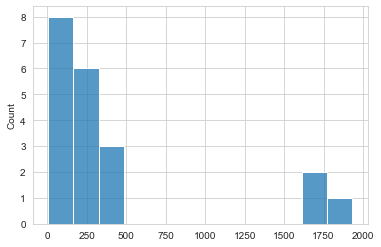

In [38]:
l = []
for i in nl_containers:
    l.append(i.size)
sns.histplot(l)

In [39]:
b = {'numpy': '1.15.2', 'pandas': '0.23.0', 'matplotlib': '3.0.0', 'ipywidgets': '7.2.1', 'ipython': '6.4.0'}

In [40]:
{k: b[k] for k in dep_list if k in b}

{'matplotlib': '3.0.0',
 'numpy': '1.15.2',
 'pandas': '0.23.0',
 'ipywidgets': '7.2.1',
 'ipython': '6.4.0'}

<a name='results'></a>
## X. Results

<br>

In [41]:
def to_dataframe(l1, l2, hue):
    return pd.DataFrame(
    {'x': l1,
     'y': l2,
     'hue': hue
    })

def to_dataframe(l1, l2, l3, hue):
    return pd.DataFrame(
    {'x': l1,
     'y': l2,
     'z': l3,
     'hue': hue
    })

In [42]:
stopper

NameError: name 'stopper' is not defined

### How long to run:

In [499]:
def model_speeds(given, amount):
    for model in ["naive", "lru_c", "lru_i", "land"]:
        start = time.time()
        MODEL_nl(model, "timeit", [-1, -1, -1], True, 0.7, False, False, 1)
        end = time.time()
        time4one = (end - start) / 500
    
        if given == "amount":
            print(str(amount) + " launches computed in: " + str(model))
            print("Time for 1000: " + str(time4one * 1000))
            print("Seconds: " + str(time4one * amount))
            print("Minutes: " + str(time4one * amount / 60))
            print("Hours: " + str(time4one * amount / 60 / 60))
            print("------------------------------------------------")
            
        if given == "time":
            print("Launches computed in " + str(amount) + " hours: " + str(model))
            print("Time for 1000: " + str(time4one * 1000))
            seconds = amount * 60 * 60
            print("Launches: " + str(seconds / time4one))
            print("------------------------------------------------")
        
model_speeds("amount", 811000)

811000 launches computed in: naive
Time for 1000: 1.8815679550170898
Seconds: 1525.9516115188599
Minutes: 25.432526858647666
Hours: 0.42387544764412777
------------------------------------------------
811000 launches computed in: lru_c
Time for 1000: 1.5646958351135254
Seconds: 1268.968322277069
Minutes: 21.149472037951153
Hours: 0.3524912006325192
------------------------------------------------
811000 launches computed in: lru_i
Time for 1000: 1.5058298110961914
Seconds: 1221.2279767990112
Minutes: 20.353799613316855
Hours: 0.33922999355528094
------------------------------------------------
811000 launches computed in: land
Time for 1000: 4.215507984161377
Seconds: 3418.7769751548767
Minutes: 56.97961625258128
Hours: 0.9496602708763546
------------------------------------------------


### Optimization on two parameters, ct_size and cache_size

https://scipy-lectures.org/intro/scipy/auto_examples/plot_2d_minimization.html

Input: 2 Mutable factors, Output: 1 Immutable factor

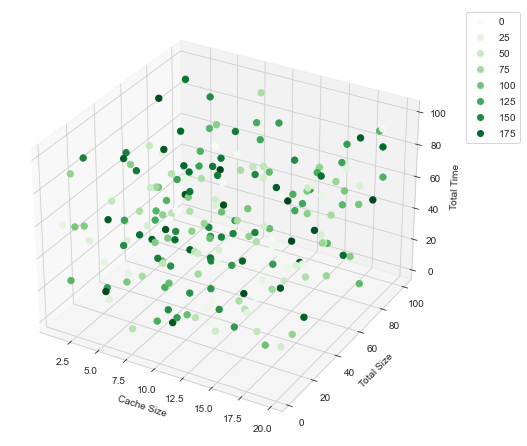

In [53]:
def scatter_3d(x=np.random.uniform(1, 20, size=200), y=np.random.uniform(1, 100, size=200),
              z=np.random.uniform(1, 100, size=200), hue=np.arange(200)):

    # axes instance
    fig = plt.figure(figsize=(6,6))
    ax = Axes3D(fig)
    fig.add_axes(ax)

    # get colormap from seaborn
    cmap = ListedColormap(sns.color_palette("Greens", 256).as_hex())

    # plot
    sc = ax.scatter(x, y, z, s=40, c=hue, marker='o', cmap=cmap, alpha=1)
    ax.set_xlabel('Cache Size')
    ax.set_ylabel('Total Size')
    ax.set_zlabel('Total Time')

    # legend
    plt.legend(*sc.legend_elements(), bbox_to_anchor=(1.05, 1), loc=2)

scatter_3d()

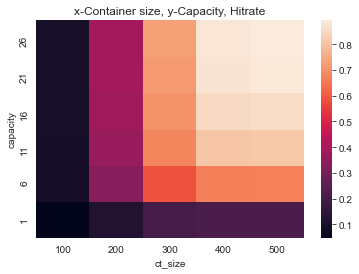

In [52]:
def visualize_2param_2D(model_type):
    ct_size, capacity, z_fact = [], [], []
    x_min, x_max, x_gap = 100, 600, 100
    y_min, y_max, y_gap = 1, 30, 5
    
    for i in np.arange(x_min, x_max, x_gap):
        for j in np.arange(y_min, y_max, y_gap):
            temp = MODEL_nl(model_type, "timeit", [i, -1, j])
            ct_size.append(i)
            capacity.append(j)
            z_fact.append(temp[6])
            
    data = pd.DataFrame(data={'ct_size': ct_size, 'capacity': capacity, 'hitrate': z_fact})
    data = data.pivot(columns='ct_size', index='capacity', values='hitrate')
    ax = sns.heatmap(data)
    sns.color_palette("Greens")
    ax.invert_yaxis()
    plt.title("x-Container size, y-Capacity, Hitrate")
    plt.show()
    
    return
        
    

visualize_2param_2D("lru_c")

Input: Mutable factor, Output: 2 Immutable factors

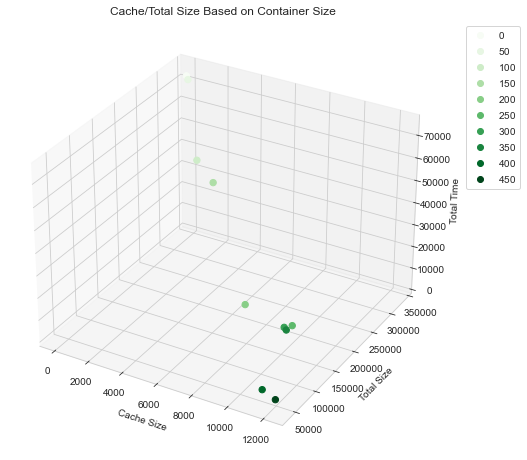

In [54]:
def RESULT_cc_sizes_basic_scatterplot(cap = False, plot_type = "2d"):
    cache_size, total_size, total_time, ct_size = [], [], [], []
    hitrate = []
    
    if cap:
        huerange = np.arange(0, 30, 5)
    else:
        huerange = np.arange(0, 500, 50)
    
    for i in huerange:
        if cap:
            temp = MODEL_nl("land", "timeit", [-1, -1, i], 0.5)
        else:
            temp = MODEL_nl("land", "timeit", [i, -1, -1], 0.5)
        total_size.append(temp[4])
        total_time.append(temp[5])
        cache_size.append(temp[7].get_total_size())
        hitrate.append(temp[6])
        ct_size.append(i)
    
    if plot_type == "3d":
        scatter_3d(cache_size, total_size, total_time, ct_size)
    elif plot_type == "2d":
        sns.scatterplot(x=cache_size, y=total_size, hue=ct_size)
        plt.xlabel("Cache Size")
        plt.ylabel("Total Size")
    elif plot_type == "pair":
        df_3d = pd.DataFrame(
            {'Cache Size': cache_size,
             'Total Size': total_size,
             'Total Time': total_time,
             'Container Size': ct_size,
             'Hitrate': hitrate
            })
        sns.pairplot(df_3d, hue='Container Size')
        
    
        
    
    if plot_type == "pair":
        pass
    elif cap:
        plt.title("Cache/Total Size Based on Capacity")
    else:
        plt.title("Cache/Total Size Based on Container Size")
    return
        
    
RESULT_cc_sizes_basic_scatterplot(False, "3d")

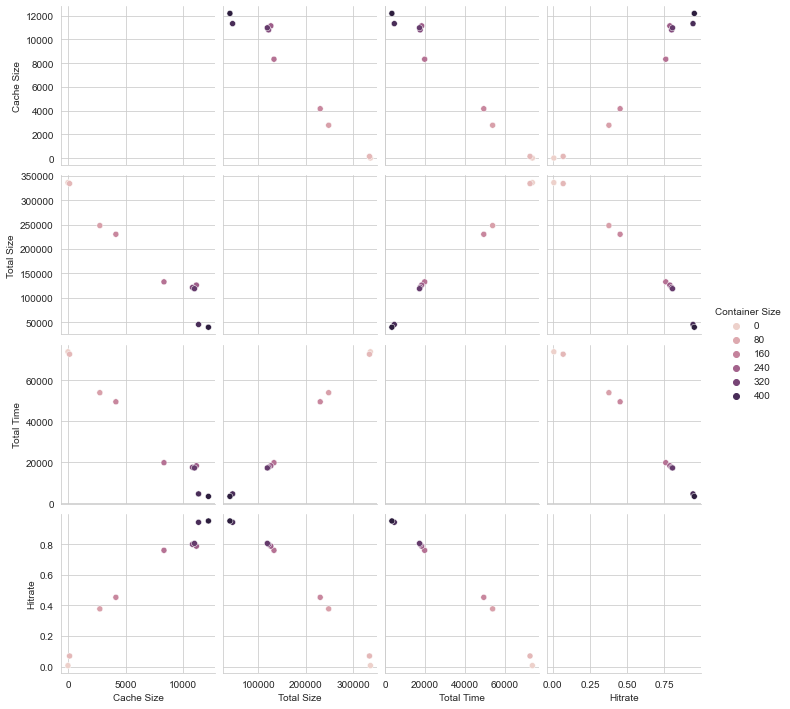

In [55]:
RESULT_cc_sizes_basic_scatterplot(False, "pair")

Attempts to combine capacity and container size as a single input, somehow.

In [ ]:
'''
def RESULT_cc_sizes_basic_scatterplot(threeD = False):
    cache_size, total_size, total_time, ct_size = [], [], [], []
    
    if cap:
        huerange = np.arange(0, 30, 5)
    else:
        huerange = np.arange(0, 400, 50)
    
    for i in huerange:
        if cap:
            temp = MODEL_nl("lru_c", "timeit", [-1, -1, i])
        else:
            temp = MODEL_nl("lru_c", "timeit", [i, -1, -1])
        total_size.append(temp[4])
        total_time.append(temp[5])
        cache_size.append(temp[7].get_total_size())
        ct_size.append(i)
    
    if threeD:
        sns.scatterplot(x=cache_size, y=total_size, z=total_time, hue=ct_size)
        plt.zlabel("Total Time")
    else:
        sns.scatterplot(x=cache_size, y=total_size, hue=ct_size)
        
    plt.xlabel("Cache Size")
    plt.ylabel("Total Size")
    
    if cap:
        plt.title("Cache/Total Size Based on Capacity")
    else:
        plt.title("Cache/Total Size Based on Container Size")
    return
        
    
RESULT_cc_sizes_basic_scatterplot(False, True)
'''

### Basic: Infinite capacity and container size. Finds total size and time.

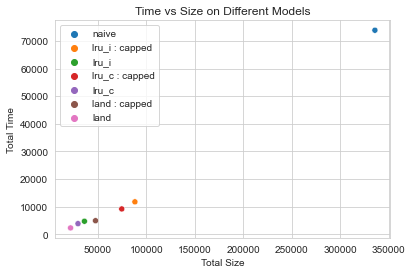

In [56]:
def RESULT_size_time_scatterplot(version):

    sizes, times, names = [], [], []
    
    for i in ["naive", "lru_i", "lru_c", "land"]:
        if i != "naive":
            temp = MODEL_nl(i, "timeit", [400, -1, 20], version)
            sizes.append(temp[4])
            times.append(temp[5])
            names.append(i + " : capped")
            
        temp = MODEL_nl(i, "timeit", [-1, -1, -1], version)
        sizes.append(temp[4])
        times.append(temp[5])
        names.append(i)
        
    sns.scatterplot(x=sizes, y=times, hue=names)
    plt.xlabel("Total Size")
    plt.ylabel("Total Time")
    plt.title("Time vs Size on Different Models")
    return
        
    
RESULT_size_time_scatterplot(False)

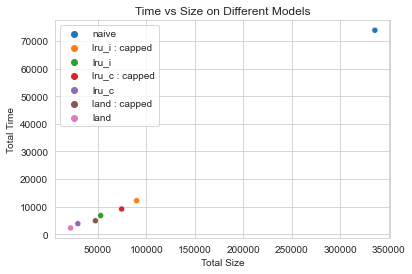

In [57]:
RESULT_size_time_scatterplot(True)

### LANDLORD

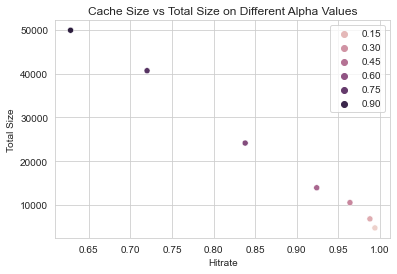

In [227]:
def RESULT_land_alpha_scatterplot():

    csize, tsize, names = [], [], []
    
    for i in np.arange(0.05, 1, 0.15):
        temp = MODEL_nl("land", "timeit", [400, -1, 5], False, i)
        #csize.append(temp[7].get_total_size())
        csize.append(temp[6])
        tsize.append(temp[4])
        names.append(i)
        
    sns.scatterplot(x=csize, y=tsize, hue=names)
    plt.xlabel("Hitrate")
    plt.ylabel("Total Size")
    plt.title("Cache Size vs Total Size on Different Alpha Values")
    return
        
    
RESULT_land_alpha_scatterplot()

### Full Model Runs

Return format:
 - 0: container size (constraint)
 - 1: capacity (constraint)
 - 2: total size overall
 - 3: total installation time overall
 - 4: hitrate
 - 5: total size of cache
 - 6: model name

In [487]:
def RESULT_model_nl(models, custom, version, constraints, alpha, xtra_vers, xtra_stat1, xtra_dynamic):
    
    if models == "all":
        models = ["naive", "lru_i", "lru_c", "land"]
    elif models == "set":
        models = ["lru_i", "lru_c", "land"]
        
    total_size, total_time, hitrate, cache_size, names, timeit = [], [], [], [], [], []
    
    for model in models:
        start = time.time()
        
        temp = MODEL_nl(model, custom, constraints, version, alpha, xtra_vers, xtra_stat1, xtra_dynamic)
        
        total_size.append(temp[4])
        total_time.appexnd(temp[5])
        hitrate.append(temp[6])
        cache_size.append(temp[7].get_total_size())
        
        end = time.time()
        timeit.append(end - start)
        
        names.append(model)
    

    return models, custom, constraints, version, alpha, xtra_vers, xtra_stat1, xtra_dynamic, total_size, total_time, hitrate, cache_size, names, timeit

RESULT_model_nl("all", 1, False, [-1, -1, -1], False, False, False, False)

(['naive', 'lru_i', 'lru_c', 'land'],
 1,
 [5, -1, -1],
 False,
 False,
 False,
 False,
 False,
 [43203.708, 43203.708, 43203.708, 30742.708000000002],
 [9300.6002119909, 9300.6002119909, 9300.6002119909, 6644.9965053364995],
 [0, 0.01, 0.01, 0.32],
 [0, 4.408, 4.408, 3789.168],
 ['naive', 'lru_i', 'lru_c', 'land'],
 [0.18999886512756348,
  0.15098214149475098,
  0.15097784996032715,
  0.2685849666595459])

In [502]:
for j in [7, 10, 13, 16, 20, 25, 30]:
    print(j)
    print(RESULT_model_nl("all", "tests", True, [-1, -1, j], 0.7, False, False, False))
    
   

7
99999
199999
299999
399999
499999
599999
699999
799999
99999
199999
299999
399999
499999
599999
699999
799999
99999
199999
299999
399999
499999
599999
699999
799999
99999
199999
299999
399999
499999
599999
699999
799999
(['naive', 'lru_i', 'lru_c', 'land'], 'tests', [-1, -1, 7], True, 0.7, False, False, False, [181140440.25199997, 99398225.95599997, 79137645.75199999, 41093163.932], [27338235.66300732, 14484713.719553936, 11147259.816995334, 4070806.5008368455], [0, 0.5809743767338623, 0.7199015049093492, 0.885069342170614], [0, 1079.2920000000001, 2480.1600000000008, 4508.252], ['naive', 'lru_i', 'lru_c', 'land'], [721.5544369220734, 456.0415940284729, 396.30469703674316, 3413.982008934021])
10
99999
199999
299999
399999
499999
599999
699999
799999
99999
199999
299999
399999
499999
599999
699999
799999
99999
199999
299999
399999
499999
599999
699999
799999
99999
199999
299999
399999
499999
599999
699999
799999
(['naive', 'lru_i', 'lru_c', 'land'], 'tests', [-1, -1, 10], True, 0.7, F

KeyboardInterrupt: 

In [ ]:
'''
results = RESULT_model_nl("all", 1, False, [-1, -1, -1], False, False, False, False)

outF = open("model_results.txt", "a")
for i in results:
  # write line to output file
  outF.write(str(i))
  outF.write("\n")

outF.write("\n")
outF.write("----------------------------")
outF.write("\n")
outF.close()
'''